In [1]:
import torch

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
! pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d859990cc5dce26d60d3add4badc3c5269521deee6ffb1360e58bf939e12f88d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
import wget
import os

### 数据加载

In [7]:
print('Downloading dataset...')
url = 'https://data.deepai.org/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

In [8]:
if not os.path.exists('./cola_public/'):
  ! unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('./cola_public/raw/in_domain_train.tsv', delimiter='\t', header=None, names=['sentence_source', 'label', 'label_note', 'sentence'])

In [11]:
df.head()

,sentence_source,label,label_note,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [12]:
df.shape

(8551, 4)

In [13]:
df.sample(10)

,sentence_source,label,label_note,sentence
2743,l-93,1,NaN,Carmen bought a dress from Diana.
1626,r-67,1,NaN,How brave everybody must think you expect me t...
1697,r-67,1,NaN,Maxwell isn't half the doctor that feared Marg...
5762,c_13,1,NaN,I did not have a red cent.
7279,sks13,1,NaN,Harry likes movies.
498,bc01,1,NaN,John believes Sally to be polite.
5210,kl93,0,*,Every boy has any potatoes.
6271,c_13,1,NaN,Susan begged to be allowed to sing in the conc...
2552,l-93,0,*,Cheryl stood the shelf with the books.
7347,sks13,1,NaN,I handed the ball to Reg.


In [14]:
df.loc[df['label'] == 0].sample(5)[['sentence', 'label']]

,sentence,label
3405,Phyllis lingered Sasha over lunch.,0
6240,It is reluctant that Jean left.,0
2672,The book sent to Peter.,0
1326,What exploded when and I warned you it would?,0
2620,Doug removed the scratches to nowhere.,0


In [15]:
sentences = df.sentence.values
labels = df.label.values

In [16]:
! pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 6.5 MB 32.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### 预处理
* tokenize
* convert to ids
* attention mask
* convert to tensors

In [17]:
from transformers import BertTokenizer

In [18]:
print('Loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading Bert tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
print(' Original : ', sentences[0])
print('Tokenized : ', tokenizer.tokenize(sentences[0]))
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original :  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized :  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs :  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [22]:
max_len = 0
for sent in sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  max_len = max(max_len, len(input_ids))

print('Max sentence length : ', max_len)

Max sentence length :  47


In [23]:
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]', 'what', 'all', 'did', 'you', 'get', 'for', 'christmas', '?', '[SEP]']

In [24]:
input_ids, sent

([101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029, 102],
 'What all did you get for Christmas?')

In [25]:
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
                    sent,
                    add_special_tokens=True,
                    max_length=64,
                    padding='max_length',
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt'
                 )
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

In [26]:
attention_masks[0]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [27]:
encoded_dict

{'input_ids': tensor([[ 101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [28]:
input_ids[0].shape

torch.Size([1, 64])

In [29]:
input_ids = torch.cat(input_ids, dim=0)

In [30]:
input_ids.shape

torch.Size([8551, 64])

In [31]:
attention_masks = torch.cat(attention_masks, dim=0)
attention_masks.shape

torch.Size([8551, 64])

In [32]:
labels = torch.tensor(labels)
labels.shape

torch.Size([8551])

In [33]:
print('Original  : ', sentences[0])
print('Token IDs : ', input_ids[0])
print('Labels    : ', labels[0])

Original  :  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs :  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Labels    :  tensor(1)


In [34]:
! pip install torch.utils

  Created wheel for torch.utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6202 sha256=03a930a7d24f455da63da937b3926204ed4c5fbbe7e1a67095d90fe7942a6fe1
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch.utils


### 数据集划分
* 将所有tensors 合并组成完整数据集
* 按需将完整数据集划分为训练集和验证集

In [35]:
from torch.utils.data import TensorDataset, random_split

In [36]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,d} training samples'.format(train_size))
print('{:>5,d} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


### 设置数据加载器 确定batch_size
**Bert 作者建议：在 fine-tune 过程中设置batch_size 为 16 或者 32**

In [40]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [41]:
batch_size = 32

train_dataloader = DataLoader(
                            train_dataset,
                            sampler = RandomSampler(train_dataset),
                            batch_size = batch_size
                   )

validation_dataloader = DataLoader(
                                 val_dataset,
                                 sampler = SequentialSampler(val_dataset),
                                 batch_size = batch_size 
                        )

### 选择模型

在本任务中，首先需要将预训练 BERT 模型改为分类模型。接着，用我们的数据集来训练这个模型，以使该模型能够端到端的、很好的适应于我们的任务。

huggingface 的 pytorch 实现包含一系列接口，就是为不同的 NLP 任务设计的。这些接口无一例外的构建于 BERT 模型之上，对于不同的 NLP 任务，它们有不同的结构和不同的输出类型。

以下是当前提供给 fine-tune 的类列表：

* BertModel
* BertForPreTraining
* BertForNextSentencePrediction
* BertForNextSentencePrediction
* BertForSequenceClassification - 本次使用该类做文本分类任务
* BertForTokenClassification
* BertForQuestionAnswering


In [43]:
from transformers import BertForSequenceClassification, BertConfig

In [44]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # 设置使用的预训练模型
    num_labels = 2, # 设置分类数，本次设置为2分类，可以改变该参数数值以实现多分类
    output_attentions = False, # 模型是否返回 attention weights
    output_hidden_states = False # 模型是否返回所有隐藏层状态
)

model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [45]:
# 将 bert 中的所有参数转化为一个列表便于查看
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('=======Embedding Layer=======\n')
for p in params[0:5]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n=======First Transformer=======\n')
for p in params[5:21]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n=======Output Layer=======\n')
for p in params[-4:]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

=======Embedding Layer=======

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=======First Transformer=======

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias       

### 调节超参数&配置warmup

在微调过程中，BERT 的作者建议使用以下超参 :

* 批量大小：16, 32
* 学习率（Adam）：5e-5, 3e-5, 2e-5
* epochs 的次数：2, 3, 4

In [46]:
from torch.optim import AdamW

In [47]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [48]:
from transformers import get_linear_schedule_with_warmup

In [175]:
epochs = 4
# 总的训练样本数
total_steps = len(train_dataloader) * epochs
# 创建学习率调度器
scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 50,
                                             num_training_steps = total_steps
                                             )

### 完善测评方法

In [50]:
import numpy as np

In [51]:
# 定义计算准确率的函数， 根据预测结果和标签数据来计算准确率
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [53]:
import time
import datetime

In [54]:
# 将输入的秒 格式化
def format_time(elapsed):
  # 四舍五入到最近的秒
  elapsed_rounded = int(round(elapsed))
  # 格式化为 hh:mm:ss
  return str(datetime.timedelta(seconds = elapsed_rounded))

### 模型训练

In [176]:
import random
import numpy as np

# 以下训练代码是基于 `run_glue.py` 脚本:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# 设定随机种子值，以确保输出是确定的
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 存储训练和评估的 loss、准确率、训练时长等统计指标, 
training_stats = []

# 统计整个训练时长
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 统计单次 epoch 的训练时间
    t0 = time.time()

    # 重置每次 epoch 的训练总 loss
    total_train_loss = 0

    # 将模型设置为训练模式。这里并不是调用训练接口的意思
    # dropout、batchnorm 层在训练和测试模式下的表现是不同的 (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # 训练集小批量迭代
    for step, batch in enumerate(train_dataloader):

        # 每经过40次迭代，就输出进度信息
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 准备输入数据，并将其拷贝到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 每次计算梯度前，都需要将梯度清 0，因为 pytorch 的梯度是累加的
        model.zero_grad()        

        # 前向传播
        # 文档参见: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # 该函数会根据不同的参数，会返回不同的值。 本例中, 会返回 loss 和 logits -- 模型的预测结果
        model_output1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = model_output1.loss, model_output1.logits
        # 累加 loss
        total_train_loss += loss.item()

        # 反向传播
        loss.backward()

        # 梯度裁剪，避免出现梯度爆炸情况
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 更新参数
        optimizer.step()

        # 更新学习率
        scheduler.step()

    # 平均训练误差
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # 单次 epoch 的训练时长
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # 完成一次 epoch 训练后，就对该模型的性能进行验证

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 设置模型为评估模式
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # 将输入数据加载到 gpu 中
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 评估的时候不需要更新参数、计算梯度
        with torch.no_grad():        
             model_output2 = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        loss = model_output2.loss
        logits = model_output2.logits
        # 累加 loss
        total_eval_loss += loss.item()

        # 将预测结果和 labels 加载到 cpu 中计算
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 计算准确率
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # 打印本次 epoch 的准确率
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 统计本次 epoch 的 loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # 统计本次评估的时长
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # 记录本次 epoch 的所有统计信息
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:55.
  Batch   120  of    241.    Elapsed: 0:01:23.
  Batch   160  of    241.    Elapsed: 0:01:50.
  Batch   200  of    241.    Elapsed: 0:02:18.
  Batch   240  of    241.    Elapsed: 0:02:46.

  Average training loss: 0.15
  Training epcoh took: 0:02:46

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.63
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:28.
  Batch    80  of    241.    Elapsed: 0:00:55.
  Batch   120  of    241.    Elapsed: 0:01:23.
  Batch   160  of    241.    Elapsed: 0:01:50.
  Batch   200  of    241.    Elapsed: 0:02:17.
  Batch   240  of    241.    Elapsed: 0:02:45.

  Average training loss: 0.10
  Training epcoh took: 0:02:45

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.80
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

In [207]:
### 评测分析

In [177]:
# 保留 2 位小数
pd.set_option('precision', 2)

# 加载训练统计到 DataFrame 中
df_stats = pd.DataFrame(data=training_stats)

# 使用 epoch 值作为每行的索引
df_stats.set_index('epoch', drop=True, inplace=True)

# 展示表格数据
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.63,0.81,0:02:46,0:00:06
2,0.10,0.80,0.81,0:02:45,0:00:06
3,0.09,0.85,0.82,0:02:45,0:00:06
4,0.09,0.88,0.81,0:02:46,0:00:06


In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

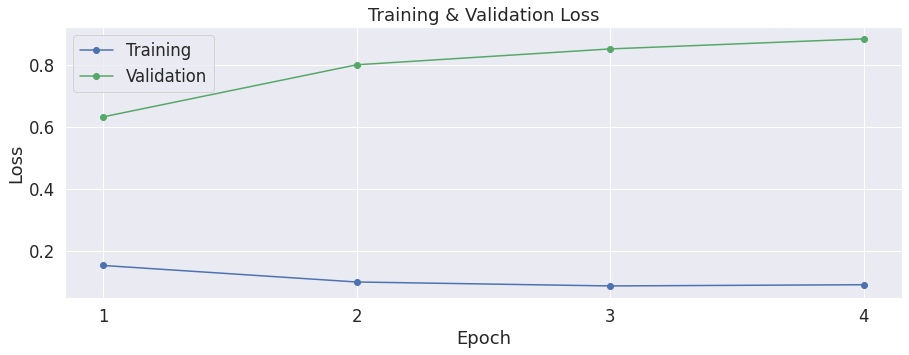

In [206]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(df_stats['Training Loss'], 'b-o', label='Training')
ax.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')
ax.set_title('Training & Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_xticks(range(1,epochs+1))
plt.show()
# 由图像看本次训练过拟合了

### 测试集测试

In [208]:
import pandas as pd


In [211]:
df = pd.read_csv('./cola_public/raw/out_of_domain_dev.tsv', 
                 delimiter='\t', 
                 header=None, 
                 names=['sentence_source', 'label', 'label_notes', 'sentence']
                 )

In [212]:
df.shape

(516, 4)

In [213]:
sentences = df.sentence.values
labels = df.label.values

In [221]:
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(sent,
                                       add_special_tokens = True,
                                       max_length = 64,
                                       padding = 'max_length',
                                       truncation = True,
                                       return_attention_mask = True,
                                       return_tensors = 'pt')
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

In [222]:
input_ids = torch.cat(input_ids,dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
input_ids.shape, attention_masks.shape, labels.shape

(torch.Size([516, 64]), torch.Size([516, 64]), torch.Size([516]))

In [224]:
batch_size = 32

prediction_dataset = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_dataset)
prediction_dataloader = DataLoader(prediction_dataset,
                                   sampler = prediction_sampler,
                                   batch_size = batch_size)

In [229]:
print('Predicting labels for {:}, test sentence...'.format(len(input_ids)))

model.eval()

predictions, true_labels = [], []

for batch in prediction_dataloader:
  b_input_ids, b_input_mask, b_labels = [b_data.to(device) for b_data in batch]

  with torch.no_grad():
    outputs = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask
                              )
  
  logits = outputs[0]

  logits = logits.to('cpu').numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('.  Done')

Predicting labels for 516, test sentence...
.  Done


In [242]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


### 由于类别分配不均匀，最终评测应使用Matthews 相关性系数(MCC) 来评估测试集性能。

Calculating Matthews Corr. Coef. for each batch...


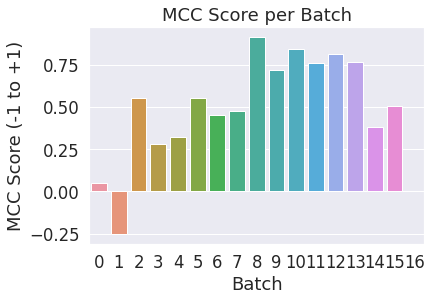

In [252]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# 计算每个 batch 的 MCC
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # 计算该 batch 的 MCC  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

# 创建柱状图来显示每个 batch 的 MCC 分数
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

ax.set_title('MCC Score per Batch')
ax.set_ylabel('MCC Score (-1 to +1)')
ax.set_xlabel('Batch')

plt.show()

In [253]:
# 合并所有 batch 的预测结果
flat_predictions = np.concatenate(predictions, axis=0)

# 取每个样本的最大值作为预测值
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# 合并所有的 labels
flat_true_labels = np.concatenate(true_labels, axis=0)

# 计算 MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.519


In [255]:
import os

# 模型存储到的路径
output_dir = './model_save/'

# 目录不存在则创建
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 使用 `save_pretrained()` 来保存已训练的模型，模型配置和分词器
# 它们后续可以通过 `from_pretrained()` 加载
model_to_save = model.module if hasattr(model, 'module') else model  # 考虑到分布式/并行（distributed/parallel）训练
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [ ]:
# 加载微调后的模型
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# 将模型 copy 到 GPU/CPU 中运行
model.to(device)